<a href="https://colab.research.google.com/github/Burgunthy/Pytorch_UNET/blob/master/Pytorch_UNET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

from torchvision import transforms, datasets
from PIL import Image
import matplotlib.pyplot as plt

In [ ]:
# parameter 설정

lr = 1e-3
batch_size = 64
num_epoch = 10

data_dir = './drive/My Drive/Colab Notebooks/Pytorch_Unet/datasets'
ckpt_dir = './drive/My Drive/Colab Notebooks/Pytorch_Unet/checkpoint'     # 체크 포인트. 주기마다 모델 저장
log_dir = './drive/My Drive/Colab Notebooks/Pytorch_Unet/log'             # 텐서 보드 확인을 위한 로그 저장

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')   # CUDA 디바이스 설정


In [ ]:
# Networt 구축

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        def CBR2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True):    # Conv, B-norm, ReLU
            layers = []
            layers += [nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                                 kernel_size=kernel_size, stride=stride, padding=padding,
                                 bias=bias)]
            layers += [nn.BatchNorm2d(num_features=out_channels)]
            layers += [nn.ReLU()]

            cbr = nn.Sequential(*layers)        # 하나의 function으로 정의

            return cbr

        # Contracting path
        self.enc1_1 = CBR2d(in_channels=1, out_channels=64)         # predefine이므로 나머지는 작성하지 않는다
        self.enc1_2 = CBR2d(in_channels=64, out_channels=64)        # 인코더의 첫번째 파트

        self.pool1 = nn.MaxPool2d(kernel_size=2)                    # 빨간색 화살표

        self.enc2_1 = CBR2d(in_channels=64, out_channels=128)
        self.enc2_2 = CBR2d(in_channels=128, out_channels=128)

        self.pool2 = nn.MaxPool2d(kernel_size=2)

        self.enc3_1 = CBR2d(in_channels=128, out_channels=256)
        self.enc3_2 = CBR2d(in_channels=256, out_channels=256)

        self.pool3 = nn.MaxPool2d(kernel_size=2)

        self.enc4_1 = CBR2d(in_channels=256, out_channels=512)
        self.enc4_2 = CBR2d(in_channels=512, out_channels=512)

        self.pool4 = nn.MaxPool2d(kernel_size=2)

        self.enc5_1 = CBR2d(in_channels=512, out_channels=1024)     # 마지막 중간 Encoder 파트


        # 오른쪽 Expansive path
        self.dec5_1 = CBR2d(in_channels=1024, out_channels=512)     # Encoder와의 명명 매치

        self.unpool4 = nn.ConvTranspose2d(in_channels=512, out_channels=512,                # Up-Conv 구현
                                          kernel_size=2, stride=2, padding=0, bias=True)

        self.dec4_2 = CBR2d(in_channels=2 * 512, out_channels=512)  # Enc 출력이 붙으므로 (* 2)가 붙는다. 
        self.dec4_1 = CBR2d(in_channels=512, out_channels=256)

        self.unpool3 = nn.ConvTranspose2d(in_channels=256, out_channels=256,
                                          kernel_size=2, stride=2, padding=0, bias=True)

        self.dec3_2 = CBR2d(in_channels=2 * 256, out_channels=256)
        self.dec3_1 = CBR2d(in_channels=256, out_channels=128)

        self.unpool2 = nn.ConvTranspose2d(in_channels=128, out_channels=128,
                                          kernel_size=2, stride=2, padding=0, bias=True)

        self.dec2_2 = CBR2d(in_channels=2 * 128, out_channels=128)
        self.dec2_1 = CBR2d(in_channels=128, out_channels=64)

        self.unpool1 = nn.ConvTranspose2d(in_channels=64, out_channels=64,
                                          kernel_size=2, stride=2, padding=0, bias=True)

        self.dec1_2 = CBR2d(in_channels=2 * 64, out_channels=64)
        self.dec1_1 = CBR2d(in_channels=64, out_channels=64)

        self.fc = nn.Conv2d(in_channels=64, out_channels=1, kernel_size=1, stride=1, padding=0, bias=True)      # 녹색 화살표. 1 x 1

    def forward(self, x):                               # 각각의 layer 연결
        enc1_1 = self.enc1_1(x)
        enc1_2 = self.enc1_2(enc1_1)
        pool1 = self.pool1(enc1_2)

        enc2_1 = self.enc2_1(pool1)
        enc2_2 = self.enc2_2(enc2_1)
        pool2 = self.pool2(enc2_2)

        enc3_1 = self.enc3_1(pool2)
        enc3_2 = self.enc3_2(enc3_1)
        pool3 = self.pool3(enc3_2)

        enc4_1 = self.enc4_1(pool3)
        enc4_2 = self.enc4_2(enc4_1)
        pool4 = self.pool4(enc4_2)

        enc5_1 = self.enc5_1(pool4)

        dec5_1 = self.dec5_1(enc5_1)

        unpool4 = self.unpool4(dec5_1)
        cat4 = torch.cat((unpool4, enc4_2), dim=1)      # cat 함수를 이용하여 Enc와 UpConv 합
                                                        # dim = [0:batch, 1:channel, 2:height, 3:width]
        dec4_2 = self.dec4_2(cat4)
        dec4_1 = self.dec4_1(dec4_2)

        unpool3 = self.unpool3(dec4_1)
        cat3 = torch.cat((unpool3, enc3_2), dim=1)
        dec3_2 = self.dec3_2(cat3)
        dec3_1 = self.dec3_1(dec3_2)

        unpool2 = self.unpool2(dec3_1)
        cat2 = torch.cat((unpool2, enc2_2), dim=1)
        dec2_2 = self.dec2_2(cat2)
        dec2_1 = self.dec2_1(dec2_2)

        unpool1 = self.unpool1(dec2_1)
        cat1 = torch.cat((unpool1, enc1_2), dim=1)
        dec1_2 = self.dec1_2(cat1)
        dec1_1 = self.dec1_1(dec1_2)

        x = self.fc(dec1_1)

        return x

In [ ]:
# Dataloader 구현

class Dataset(torch.utils.data.Dataset):
    def __init__(self, data_dir, transform=None):   # 3가지의 폴더로 이루어져 있으며, input, label이 있다.
        self.data_dir = data_dir
        self.transform = transform

        lst_data = os.listdir(self.data_dir)        # data_dir 내 모든 파일을 불러온다

        lst_label = [f for f in lst_data if f.startswith('label')]      # label, startswitch를 통해 원하는 파일 얻음
        lst_input = [f for f in lst_data if f.startswith('input')]      # input

        lst_label.sort()                            # sort
        lst_input.sort()

        self.lst_label = lst_label                  # 클래스의 parameter로 가져온다
        self.lst_input = lst_input

    def __len__(self):
        return len(self.lst_label)                  # 함수의 length 확인 함수

    def __getitem__(self, index):                   # 실제 데이터 get. index를 입력받아 index 해당 파일 load
        label = np.load(os.path.join(self.data_dir, self.lst_label[index]))     # numpy 형태이므로 이와 같이 불러온다
        input = np.load(os.path.join(self.data_dir, self.lst_input[index]))

        label = label/255.0                         # 0 ~ 1 사이로 normalization -> bnorm을 나중에는 사용해보자
        input = input/255.0

        if label.ndim == 2:                         # x, y, channel axis 임의로 생성
            label = label[:, :, np.newaxis]
        if input.ndim == 2:
            input = input[:, :, np.newaxis]

        data = {'input': input, 'label': label}     # dict 형태로 output한다

        if self.transform:                          # transform 함수가 정의되어 있다면 이를 return
            data = self.transform(data)

        return data

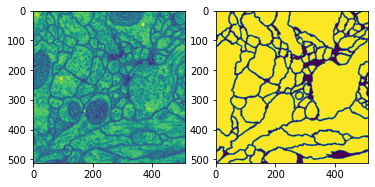

In [ ]:
## Test
dataset_train = Dataset(data_dir=os.path.join(data_dir,'train'))

##
data = dataset_train.__getitem__(0)

input = data['input']
label = data['label']

## 출력
plt.subplot(121)
plt.imshow(input.squeeze())           # 512 * 512 * 1 이다 squeeze 사용

plt.subplot(122)
plt.imshow(label.squeeze())

plt.show()

In [ ]:
# data transform 함수 구현하기

# numpy -> tensor

class ToTensor(object):
  def __call__(self, data):
    label, input = data['label'], data['input']         # numpy -> (Y, X, CH), pytorch -> (CH, Y, X)

    label = label.transpose((2, 0, 1)).astype(np.float32)
    input = input.transpose((2, 0, 1)).astype(np.float32)

    data = {'label': torch.from_numpy(label), 'input': torch.from_numpy(input)}           # 다시 dict로 만든다. numpy를 tensor로 만들어주는 from_numpy 적용

    return data


class Normalization(object):
    def __init__(self, mean=0.5, std=0.5):             # default 설정
        self.mean = mean
        self.std = std

    def __call__(self, data):
        input, label = data['input'], data['label']

        input = (input - self.mean) / self.std        # 여기서 label은 0 or 1 이므로 안해도 괜찮다
        # label = (label - self.mean) / self.std

        data = {'input': input, 'label': label}
        return data


class RandomFlip(object):                             # 좌우상하 랜덤 플립
    def __call__(self, data):
        
        input, label = data['input'], data['label']

        if np.random.rand() > 0.5:
            input = np.fliplr(input)                # 왼쪽 오른쪽
            label = np.fliplr(label)

        if np.random.rand() > 0.5:
            input = np.flipud(input)                # up down
            label = np.flipud(label)

        return {'input': input, 'label': label}


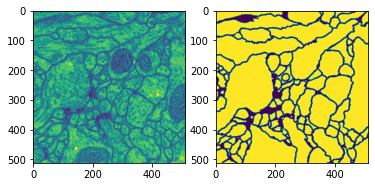

'torch.FloatTensor'

In [ ]:
## Test2
transform = transforms.Compose([Normalization(mean=0.5, std=0.5), RandomFlip(), ToTensor()])    # torchvision

dataset_train = Dataset(data_dir=os.path.join(data_dir,'train'), transform=transform)

##
data = dataset_train.__getitem__(0)

input = data['input']
label = data['label']

## 출력
plt.subplot(121)
plt.imshow(input.squeeze())           # 512 * 512 * 1 이다 squeeze 사용

plt.subplot(122)
plt.imshow(label.squeeze())

plt.show()

input.shape                           # ToTensor 함수가 적용이 된 것 확인 가능
input.type()                          # torch로 변경

In [ ]:
# 네트워크 학습

transform = transforms.Compose([Normalization(mean=0.5, std=0.5), RandomFlip(), ToTensor()])    # 다양한 transform 설정

dataset_train = Dataset(data_dir=os.path.join(data_dir,'train'), transform=transform)
loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=8)    # loader

dataset_val = Dataset(data_dir=os.path.join(data_dir,'val'), transform=transform)
loader_val = DataLoader(dataset_val, batch_size=batch_size, shuffle=False, num_workers=8)    # loader

In [ ]:
# 네트워크 생성

net = Net().to(device)                              # 앞서 설정한 Net 구조 사용 변수

# 손실함수 정의
fn_loss = nn.BCEWithLogitsLoss.to(device)          # loss 함수. CrossEntropyLoss 사용

# optimizer 설정
optim = torch.optim.Adam(net.parameters(), lr=lr)             # Adam 사용. parameters 함수 사용

# 부수적인 variables 설정
num_data_train = len(dataset_train)             # 개수 설정
num_data_val = len(dataset_val)

num_batch_train = np.ceil(num_data_train / batch_size)
num_batch_val = np.ceil(num_data_val / batch_size)

# 부수적인 functions 설정
fn_tonumpy = lambda x: x.to('cpu').detach().numpy().transpose(0, 2, 3, 1)       # tensor에서 numpy로 transfer
fn_denorm = lambda x, mean, std: (x * std) + mean                               # denormalization 함수
fn_class = lambda x: 1.0 * (x > 0.5)                                            # network output을 binary로 결정해줌 -> 0과 1만 사용

## Tensorboard 를 사용하기 위한 SummaryWriter 설정
writer_train = SummaryWriter(log_dir=os.path.join(log_dir, 'train'))
writer_val = SummaryWriter(log_dir=os.path.join(log_dir, 'val'))

In [ ]:
# 네트워크 학습

st_epoch = 0

for epoch in range(st_epoch + 1, num_epoch + 1):
        net.train()
        loss_arr = []

        for batch, data in enumerate(loader_train, 1):
            # forward pass
            label = data['label'].to(device)
            input = data['input'].to(device)

            output = net(input)

            # backward pass
            optim.zero_grad()

            loss = fn_loss(output, label)
            loss.backward()

            optim.step()

            # 손실함수 계산
            loss_arr += [loss.item()]

            print("TRAIN: EPOCH %04d / %04d | BATCH %04d / %04d | LOSS %.4f" %
                  (epoch, num_epoch, batch, num_batch_train, np.mean(loss_arr)))

            # Tensorboard 저장하기
            label = fn_tonumpy(label)
            input = fn_tonumpy(fn_denorm(input, mean=0.5, std=0.5))
            output = fn_tonumpy(fn_class(output))

            writer_train.add_image('label', label, num_batch_train * (epoch - 1) + batch, dataformats='NHWC')
            writer_train.add_image('input', input, num_batch_train * (epoch - 1) + batch, dataformats='NHWC')
            writer_train.add_image('output', output, num_batch_train * (epoch - 1) + batch, dataformats='NHWC')

        writer_train.add_scalar('loss', np.mean(loss_arr), epoch)

        with torch.no_grad():
            net.eval()
            loss_arr = []

            for batch, data in enumerate(loader_val, 1):
                # forward pass
                label = data['label'].to(device)
                input = data['input'].to(device)

                output = net(input)

                # 손실함수 계산하기
                loss = fn_loss(output, label)

                loss_arr += [loss.item()]

                print("VALID: EPOCH %04d / %04d | BATCH %04d / %04d | LOSS %.4f" %
                      (epoch, num_epoch, batch, num_batch_val, np.mean(loss_arr)))

                # Tensorboard 저장하기
                label = fn_tonumpy(label)
                input = fn_tonumpy(fn_denorm(input, mean=0.5, std=0.5))
                output = fn_tonumpy(fn_class(output))

                writer_val.add_image('label', label, num_batch_val * (epoch - 1) + batch, dataformats='NHWC')
                writer_val.add_image('input', input, num_batch_val * (epoch - 1) + batch, dataformats='NHWC')
                writer_val.add_image('output', output, num_batch_val * (epoch - 1) + batch, dataformats='NHWC')

        writer_val.add_scalar('loss', np.mean(loss_arr), epoch)

        if epoch % 50 == 0:
            save(ckpt_dir=ckpt_dir, net=net, optim=optim, epoch=epoch)

    writer_train.close()
    writer_val.close()

In [ ]:
# 네트워크 저장 함수

def save(ckpt_dir, net, optim, epoch):        # check point 저장
    if not os.path.exists(ckpt_dir):
        os.makedirs(ckpt_dir)                 # 없다면 체크 포인트 생성

    torch.save({'net': net.state_dict(), 'optim': optim.state_dict()},    # net, optim -> pth로 저장
               './%s/model_epoch%d.pth' % (ckpt_dir, epoch))              # net : , optim : 

def load(ckpt_dir, net, optim):               # check point 로드
    ckpt_lst = os.listdir(ckpt_dir)
    ckpt_lst.sort()                           # check point list 한 후 마지막 사용을 위해 sort -> 1, 10도 sort가 되는지 확인

    dict_model = torch.load('./%s/%s' % (ckpt_dir, ckpt_lst[-1]))         # 마지막 sort를 사용. dict_model에 넣어준다

    net.load_state_dict(dict_model['net'])                                # net, optim 모델에서 로드
    optim.load_state_dict(dict_model['optim'])

    return net, optim